In [213]:
import math
import time

from typing import Dict, List, Tuple, Optional
from datetime import datetime, timedelta

from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler

## dataset load

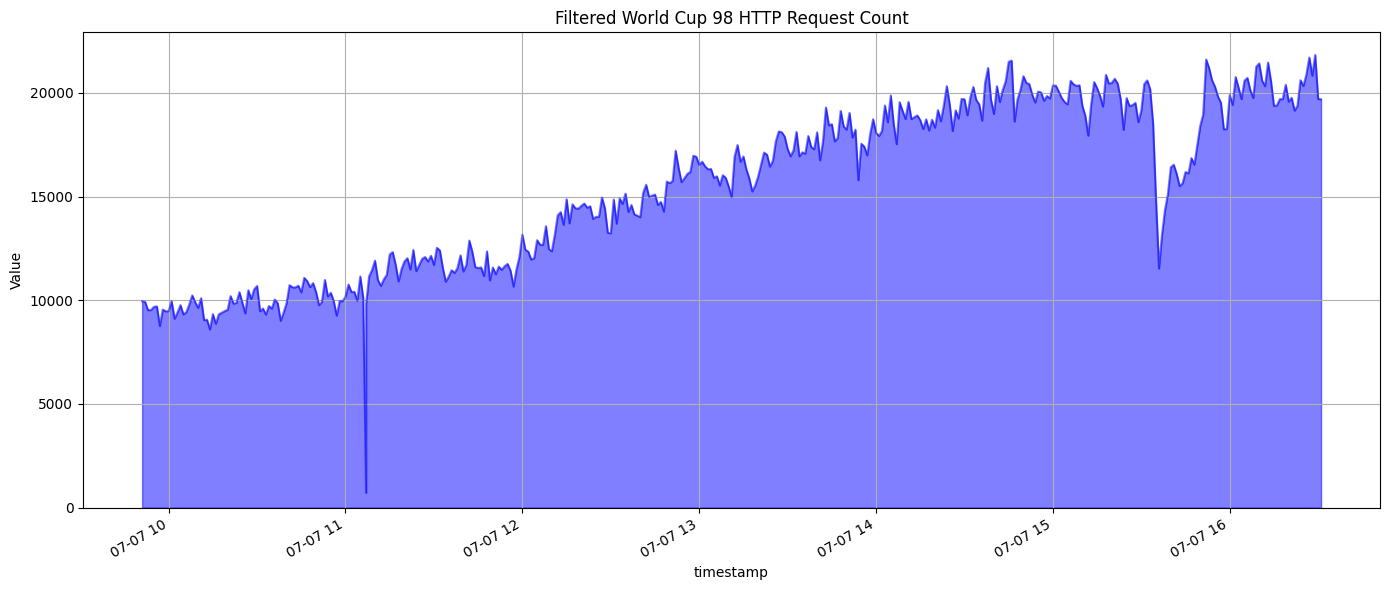

In [214]:
wcdf = pd.read_csv('/kaggle/input/fifa-wc98/merged_data.csv',
                   usecols=["timestamp", "value"],
                   index_col=["timestamp"],
                   parse_dates=["timestamp"]
                  ).sort_index()


df_filtered = wcdf.loc['1998-07-07 09:51:00':'1998-07-07 16:31:00']

plt.figure(figsize=(14, 6))

df_filtered['value'].plot(kind='area', color='blue', alpha=0.5)

plt.title('Filtered World Cup 98 HTTP Request Count')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

## helper

### model handler class

In [215]:
class ModelHandler:
    def __init__(self, model_path: str):
        self.model_path = model_path
        self.model = None
        
        self.sequence_length = 10
        self.input_shape = (1, 10, 1)

        self._load_model()
    
    def _load_model(self):
        self.model = tf.saved_model.load(self.model_path)
        
        self.serving_fn = self.model.signatures['serving_default']
        
        return True

    def _preprocess_data(self, historical_data: List, scaler: TransformerMixin):
        data_array = np.array(historical_data)
        
        scaled_data_array = scaler.fit_transform(data_array)

        reshaped_data = scaled_data_array.reshape(self.input_shape)
        
        return reshaped_data

    def _predict_raw(self, input_data: np.ndarray):
        input_tensor = tf.constant(input_data, dtype=tf.float32)
        
        input_keys = list(self.serving_fn.structured_input_signature[1].keys())
        if not input_keys:
            return None
        
        input_key = input_keys[0]
        
        prediction = self.serving_fn(**{input_key: input_tensor})
        
        output_keys = list(prediction.keys())
        if not output_keys:
            return None
        
        output_key = output_keys[0]
        pred_value = prediction[output_key].numpy()
        
        return pred_value
    
    def predict(self, historical_data: List, scaler: TransformerMixin):

        processed_data = self._preprocess_data(historical_data, scaler)
        if processed_data is None:
            return None
        
        prediction = self._predict_raw(processed_data)

        scaled_prediction = scaler.inverse_transform(prediction)[0][0]

        return scaled_prediction

### kubernetes default HPA algorithm class

In [216]:
class HpaHttpScaler:
    def __init__(self, target_requests_per_pod: int):
        self.target_requests_per_pod = target_requests_per_pod

        self.scale_up_cooldown: timedelta = timedelta(minutes=3)
        self.scale_down_cooldown: timedelta = timedelta(minutes=5)
        
        current_time = datetime.now()
        self.last_scale_up_time: datetime = current_time - self.scale_up_cooldown
        self.last_scale_down_time: datetime = current_time - self.scale_down_cooldown
    
    def get_desired_replicas(
        self, 
        current_replicas: int, 
        current_requests: int,
        current_time: datetime = None
    ):
        if current_time is None:
            current_time = datetime.now()
        
        # Handle edge cases
        if current_replicas <= 0:
            return 1
        
        if self.target_requests_per_pod <= 0:
            return current_replicas
        
        # Calculate current requests per pod
        current_requests_per_pod = current_requests / current_replicas
        
        # Apply standard HPA formula
        utilization_ratio = current_requests_per_pod / self.target_requests_per_pod
        raw_desired_replicas = math.ceil(current_replicas * utilization_ratio)
        
        # Determine if scaling up or down
        scaling_up = raw_desired_replicas > current_replicas
        scaling_down = raw_desired_replicas < current_replicas
        
        # Check cooldown periods
        if scaling_up:
            time_since_scale_up = current_time - self.last_scale_up_time
            if time_since_scale_up < self.scale_up_cooldown:
                remaining = (self.scale_up_cooldown - time_since_scale_up).total_seconds()
                return current_replicas
                
        if scaling_down:
            time_since_scale_down = current_time - self.last_scale_down_time
            if time_since_scale_down < self.scale_down_cooldown:
                remaining = (self.scale_down_cooldown - time_since_scale_down).total_seconds()
                return current_replicas
        
        # Apply rate limiting (same as default HPA)
        if scaling_up:
            max_scale_up = current_replicas * 2
            desired_replicas = min(raw_desired_replicas, max_scale_up)
            
            if desired_replicas != current_replicas:
                self.last_scale_up_time = current_time
                
        elif scaling_down:
            min_scale_down = max(1, math.ceil(current_replicas * 0.5))
            desired_replicas = max(raw_desired_replicas, min_scale_down)
            
            if desired_replicas != current_replicas:
                self.last_scale_down_time = current_time
            
        else:
            # No scaling needed
            desired_replicas = current_replicas
        
        return desired_replicas

### ai scaling algorithm class

In [217]:
@dataclass
class ScalingConfig:
    min_replicas: int
    max_replicas: int
    workload_per_pod: int
    resource_removal_strategy: float

class CustomScaling:
    def __init__(self):
        # Initialize with a time that ensures no cooldown at startup
        self.last_scaling_time: datetime = datetime.now() - timedelta(seconds=60)
    
    def _calculate_required_pods(self, predicted_workload: float, workload_per_pod: int):
        if workload_per_pod <= 0:
            return 1
            
        required_pods = math.ceil(predicted_workload / workload_per_pod)
        
        return max(1, required_pods)
    
    def _is_in_cooldown(self, current_time):
        last_scaling = self.last_scaling_time
        cooldown_end = last_scaling + timedelta(seconds=60)
        
        return current_time < cooldown_end
    
    def _get_cooldown_remaining(self, current_time):
        last_scaling = self.last_scaling_time
        cooldown_end = last_scaling + timedelta(seconds=60)
        remaining = cooldown_end - current_time
        
        return max(0, int(remaining.total_seconds()))
    
    def calculate_scaling_decision(
        self, 
        predicted_workload: float, 
        current_replicas: int, 
        config: ScalingConfig,
        current_time
    ):
        # Check if we're in cooldown period (CDT)
        if self._is_in_cooldown(current_time):
            cooldown_remaining = self._get_cooldown_remaining(current_time)
            return current_replicas
        
        pods_required = self._calculate_required_pods(predicted_workload, config.workload_per_pod)
        
        # Apply Scaling Algorithm logic
        if pods_required > current_replicas:
            # Scale out scenario
            target_replicas = min(pods_required, config.max_replicas)
            
            # Only update scaling time if we actually changed the replica count
            if target_replicas != current_replicas:
                self.last_scaling_time = current_time
            
            return target_replicas
            
        elif pods_required < current_replicas:
            # Scale in scenario with RRS
            # Step 1: Ensure we don't go below minimum
            pods_adjusted = max(pods_required, config.min_replicas)
            
            # Step 2: Calculate surplus pods using RRS
            pods_surplus = int((current_replicas - pods_adjusted) * config.resource_removal_strategy)
            
            # Step 3: Calculate final target replicas
            target_replicas = current_replicas - pods_surplus
            
            # Ensure we don't go below minimum after RRS calculation
            target_replicas = max(target_replicas, config.min_replicas)
            
            # Only update scaling time if we actually changed the replica count
            if target_replicas != current_replicas:
                self.last_scaling_time = current_time
            
            return target_replicas
            
        else:
            # No scaling needed
            return current_replicas

### get request and pods data function

In [218]:
def process_autoscaler_data(
    filtered_data: pd.DataFrame, 
    scaler: TransformerMixin, 
    model_handler_instance: ModelHandler,
    default_autoscaler_instance: HpaHttpScaler,
    ai_autoscaler_instance: CustomScaling,
    config: ScalingConfig,
    initial_replicas: int
    ):
    
    required_columns = ['value']
    missing_columns = [col for col in required_columns if col not in filtered_data.columns]
    if missing_columns:
        raise ValueError(f"Missing required columns: {missing_columns}")
    
    request_list = []
    ai_pods_list = []
    default_pods_list = []
    
    start_index = 9
    iterator = range(start_index, len(filtered_data))

    # initial data for autoscaler replicas
    current_default_replicas = initial_replicas
    current_ai_replicas = initial_replicas
    current_time = datetime.now()

    for i in iterator:
        # Proccess request data
        current_request = filtered_data.iloc[i]['value']
        request_list.append(current_request)

        # Process default autoscaler
        result_hpa_replicas = default_autoscaler_instance.get_desired_replicas(
            current_replicas=current_default_replicas, 
            current_requests=current_request,
            current_time=current_time
        )

        current_default_replicas = result_hpa_replicas
        default_pods_list.append(result_hpa_replicas)

        # Proccess ai autoscaler
        ai_input_start = i - 10 + 1
        ai_input_data = filtered_data.iloc[ai_input_start:i+1][['value']].values.tolist()

        prediction_result = model_handler_instance.predict(ai_input_data, scaler)
        
        result_ai_scaling = ai_autoscaler_instance.calculate_scaling_decision(
            predicted_workload=prediction_result, 
            current_replicas=current_ai_replicas,
            config=config,
            current_time=current_time
        )

        current_ai_replicas = result_ai_scaling
        ai_pods_list.append(result_ai_scaling)

        # add time
        current_time = current_time + timedelta(minutes=1)
    
    # Final validation
    if len(request_list) != len(ai_pods_list) or len(request_list) != len(default_pods_list):
        raise Exception("Output lists are not synchronized")

    
    return request_list, ai_pods_list, default_pods_list

### autoscaler metrics evaluator class

In [219]:
class AutoscalerEvaluator:
    """
    Evaluates autoscaler performance using metrics from research paper:
    - ΘU[%]: Under-provisioning metric
    - ΘO[%]: Over-provisioning metric  
    - TU[%]: Time duration under-provisioned
    - TO[%]: Time duration over-provisioned
    - εn: Elastic speedup (autoscaling gain)
    """
    
    def __init__(self, workload_per_pod: int, initial_replicas: int):
        self.workload_per_pod = workload_per_pod
        self.initial_replicas = initial_replicas
        
    def _calculate_required_pods(self, requests: List[int]):
        return [max(1, int(np.ceil(req / self.workload_per_pod))) for req in requests]
    
    def _calculate_theta_u(self, required_pods: List[int], provisioned_pods: List[int]):
        """
        Calculate under-provisioning metric ΘU[%].
        ΘU[%] = (100/T) * Σ(max(rt - pt, 0)/rt) * Δt
        """
        if len(required_pods) != len(provisioned_pods):
            raise ValueError("Required and provisioned pods lists must have same length")
        
        T = len(required_pods)  # Total time steps
        if T == 0:
            return 0.0
            
        theta_u_sum = 0.0
        for rt, pt in zip(required_pods, provisioned_pods):
            if rt > 0:  # Avoid division by zero
                theta_u_sum += max(rt - pt, 0) / rt
        
        return (100.0 / T) * theta_u_sum
    
    def _calculate_theta_o(self, required_pods: List[int], provisioned_pods: List[int]):
        """
        Calculate over-provisioning metric ΘO[%].
        ΘO[%] = (100/T) * Σ(max(pt - rt, 0)/rt) * Δt
        """
        if len(required_pods) != len(provisioned_pods):
            raise ValueError("Required and provisioned pods lists must have same length")
        
        T = len(required_pods)  # Total time steps
        if T == 0:
            return 0.0
            
        theta_o_sum = 0.0
        for rt, pt in zip(required_pods, provisioned_pods):
            if rt > 0:  # Avoid division by zero
                theta_o_sum += max(pt - rt, 0) / rt
        
        return (100.0 / T) * theta_o_sum
    
    def _calculate_t_u(self, required_pods: List[int], provisioned_pods: List[int]):
        """
        Calculate time duration under-provisioned TU[%].
        TU[%] = (100/T) * Σ max(sgn(rt - pt), 0) * Δt
        """
        if len(required_pods) != len(provisioned_pods):
            raise ValueError("Required and provisioned pods lists must have same length")
        
        T = len(required_pods)  # Total time steps
        if T == 0:
            return 0.0
            
        under_provisioned_count = 0
        for rt, pt in zip(required_pods, provisioned_pods):
            if rt > pt:  # sgn(rt - pt) > 0
                under_provisioned_count += 1
        
        return (100.0 / T) * under_provisioned_count
    
    def _calculate_t_o(self, required_pods: List[int], provisioned_pods: List[int]):
        """
        Calculate time duration over-provisioned TO[%].
        TO[%] = (100/T) * Σ max(sgn(pt - rt), 0) * Δt
        """
        if len(required_pods) != len(provisioned_pods):
            raise ValueError("Required and provisioned pods lists must have same length")
        
        T = len(required_pods)  # Total time steps
        if T == 0:
            return 0.0
            
        over_provisioned_count = 0
        for rt, pt in zip(required_pods, provisioned_pods):
            if pt > rt:  # sgn(pt - rt) > 0
                over_provisioned_count += 1
        
        return (100.0 / T) * over_provisioned_count
    
    def _calculate_elastic_speedup(self, 
                                ai_metrics: Dict[str, float], 
                                default_metrics: Dict[str, float]):
        """
        Calculate elastic speedup εn.
        εn = (ΘU,n + ΘO,n + TU,n + TO,n) / (ΘU,a + ΘO,a + TU,a + TO,a)^(1/4)
        
        Where 'a' is AI autoscaler and 'n' is default (no-AI) autoscaler.
        """
        # Sum of all metrics for default autoscaler (numerator)
        default_sum = (default_metrics['theta_u'] + default_metrics['theta_o'] + 
                      default_metrics['t_u'] + default_metrics['t_o'])
        
        # Sum of all metrics for AI autoscaler (denominator)
        ai_sum = (ai_metrics['theta_u'] + ai_metrics['theta_o'] + 
                 ai_metrics['t_u'] + ai_metrics['t_o'])
        
        # Avoid division by zero
        if ai_sum == 0:
            return float('inf') if default_sum > 0 else 1.0
        
        # Calculate elastic speedup with 4th root as per equation
        epsilon_n = (default_sum / ai_sum) ** (1/4)
        
        return epsilon_n
    
    def evaluate_autoscaler(self, 
                          requests: List[int], 
                          provisioned_pods: List[int],
                          autoscaler_name: str):
      
        required_pods = self._calculate_required_pods(requests)
        
        metrics = {
            'theta_u': self._calculate_theta_u(required_pods, provisioned_pods),
            'theta_o': self._calculate_theta_o(required_pods, provisioned_pods),
            't_u': self._calculate_t_u(required_pods, provisioned_pods),
            't_o': self._calculate_t_o(required_pods, provisioned_pods)
        }
        
        return metrics
    
    def compare_autoscalers(self,
                          requests: List[int],
                          ai_provisioned_pods: List[int],
                          default_provisioned_pods: List[int],
                          start_time: Optional[datetime] = None,
                          end_time: Optional[datetime] = None):
      
        # Evaluate AI autoscaler
        ai_metrics = self.evaluate_autoscaler(requests, ai_provisioned_pods, "AI Autoscaler")
        
        # Evaluate default autoscaler
        default_metrics = self.evaluate_autoscaler(requests, default_provisioned_pods, "Default Autoscaler")
        
        # Calculate elastic speedup
        elastic_speedup = self._calculate_elastic_speedup(ai_metrics, default_metrics)
        
        # Create comparison summary
        comparison = {
            'ai_metrics': ai_metrics,
            'default_metrics': default_metrics,
            'elastic_speedup': elastic_speedup
        }
        
        return comparison
    
    def plot_comparison(self,
                       requests: List[int],
                       ai_provisioned_pods: List[int],
                       default_provisioned_pods: List[int],
                       timestamps: Optional[List[datetime]]=None):
      
        required_pods = self._calculate_required_pods(requests)
        
        if timestamps is None:
            timestamps = list(range(len(requests)))

        fig, ax = plt.subplots(figsize=(14, 8))
        fig.suptitle('Autoscaler Performance Comparison', fontsize=16, fontweight='bold')

        ax.plot(timestamps, requests, label='HTTP Requests', color='green')
        ax_twin = ax.twinx()
        ax_twin.plot(timestamps, ai_provisioned_pods, label='AI Provisioned', color='blue', alpha=0.8)
        ax_twin.plot(timestamps, default_provisioned_pods, label='Default Provisioned', color='red', alpha=0.8)

        ax.set_xlabel('Time')
        ax.set_ylabel('HTTP Requests', color='blue')
        ax_twin.set_ylabel('Provisioned Pods', color='black')
        ax.tick_params(axis='y', labelcolor='blue')

        # Combine legends from both axes
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax_twin.get_legend_handles_labels()
        ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

        ax.set_title('Workload vs Pod Allocation')

        plt.tight_layout()
        plt.show()

## get autoscaler data

### intial config

In [220]:
df_scaler = MinMaxScaler(feature_range=(-1,1))


workload_per_pod = 5000
initial_replicas = 2

timestamps = df_filtered.index[9:].to_pydatetime().tolist()

### bilstm DQ predictor model

In [221]:
hpa_autoscaler = HpaHttpScaler(
    target_requests_per_pod=workload_per_pod
    )

ai_autoscaler = CustomScaling()

ai_autoscaler_config = ScalingConfig(
    min_replicas=2,
    max_replicas=25,
    workload_per_pod=workload_per_pod,
    resource_removal_strategy=0.6
)

model_BilstmDq = ModelHandler('/kaggle/input/bilstm-dq/tensorflow2/default/1/bilstm-dq')

data_evaluation_BilstmDq = process_autoscaler_data(
    filtered_data=df_filtered, 
    scaler=df_scaler, 
    model_handler_instance=model_BilstmDq,
    default_autoscaler_instance=hpa_autoscaler,
    ai_autoscaler_instance=ai_autoscaler,
    config=ai_autoscaler_config,
    initial_replicas=initial_replicas
    )

### bilstm MD predictor model

In [222]:
hpa_autoscaler = HpaHttpScaler(
    target_requests_per_pod=workload_per_pod
    )

ai_autoscaler = CustomScaling()

ai_autoscaler_config = ScalingConfig(
    min_replicas=2,
    max_replicas=25,
    workload_per_pod=workload_per_pod,
    resource_removal_strategy=0.6
)

model_BilstmMd = ModelHandler('/kaggle/input/bilstm-md/tensorflow2/default/1/bilstm-md')

data_evaluation_BilstmMd= process_autoscaler_data(
    filtered_data=df_filtered, 
    scaler=df_scaler, 
    model_handler_instance=model_BilstmMd,
    default_autoscaler_instance=hpa_autoscaler,
    ai_autoscaler_instance=ai_autoscaler,
    config=ai_autoscaler_config,
    initial_replicas=initial_replicas
    )

### bayesian bilstm predictor model

In [223]:
hpa_autoscaler = HpaHttpScaler(
    target_requests_per_pod=workload_per_pod
    )

ai_autoscaler = CustomScaling()

ai_autoscaler_config = ScalingConfig(
    min_replicas=2,
    max_replicas=25,
    workload_per_pod=workload_per_pod,
    resource_removal_strategy=0.6
)

model_BoBilstm = ModelHandler('/kaggle/input/bayes-bilstm/tensorflow2/default/1/bilstm-bo-opt')


data_evaluation_BoBilstm = process_autoscaler_data(
    filtered_data=df_filtered, 
    scaler=df_scaler, 
    model_handler_instance=model_BoBilstm,
    default_autoscaler_instance=hpa_autoscaler,
    ai_autoscaler_instance=ai_autoscaler,
    config=ai_autoscaler_config,
    initial_replicas=initial_replicas
    )

## autoscaler evaluation

### bilstm DQ predictor model

{'ai_metrics': {'theta_u': 0.0, 'theta_o': 13.27396098388464, 't_u': 0.0, 't_o': 38.16793893129771}, 'default_metrics': {'theta_u': 0.0, 'theta_o': 1.8447837150127222, 't_u': 0.0, 't_o': 3.816793893129771}, 'elastic_speedup': 0.5759769665144899}


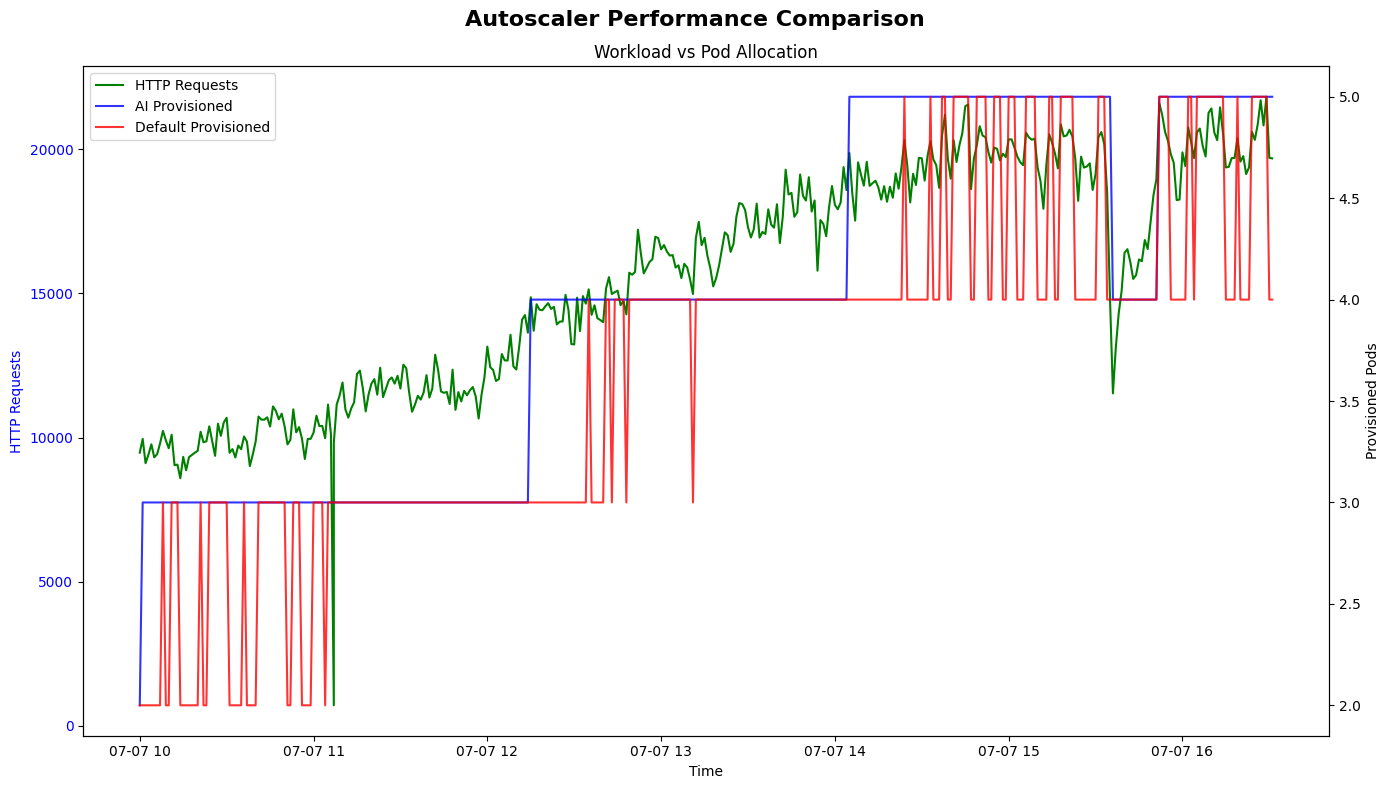

In [224]:
evaluator = AutoscalerEvaluator(workload_per_pod=workload_per_pod, initial_replicas=initial_replicas)

results = evaluator.compare_autoscalers(
    requests=data_evaluation_BilstmDq[0],
    ai_provisioned_pods=data_evaluation_BilstmDq[1],
    default_provisioned_pods=data_evaluation_BilstmDq[2]
)

print(results)

evaluator.plot_comparison(
    data_evaluation_BilstmDq[0],
    data_evaluation_BilstmDq[1],
    data_evaluation_BilstmDq[2],
    timestamps=timestamps
)

### bilstm MD predictor model

{'ai_metrics': {'theta_u': 0.0, 'theta_o': 10.55979643765903, 't_u': 0.0, 't_o': 29.770992366412212}, 'default_metrics': {'theta_u': 0.0, 'theta_o': 1.8447837150127222, 't_u': 0.0, 't_o': 3.816793893129771}, 'elastic_speedup': 0.6121039572079774}


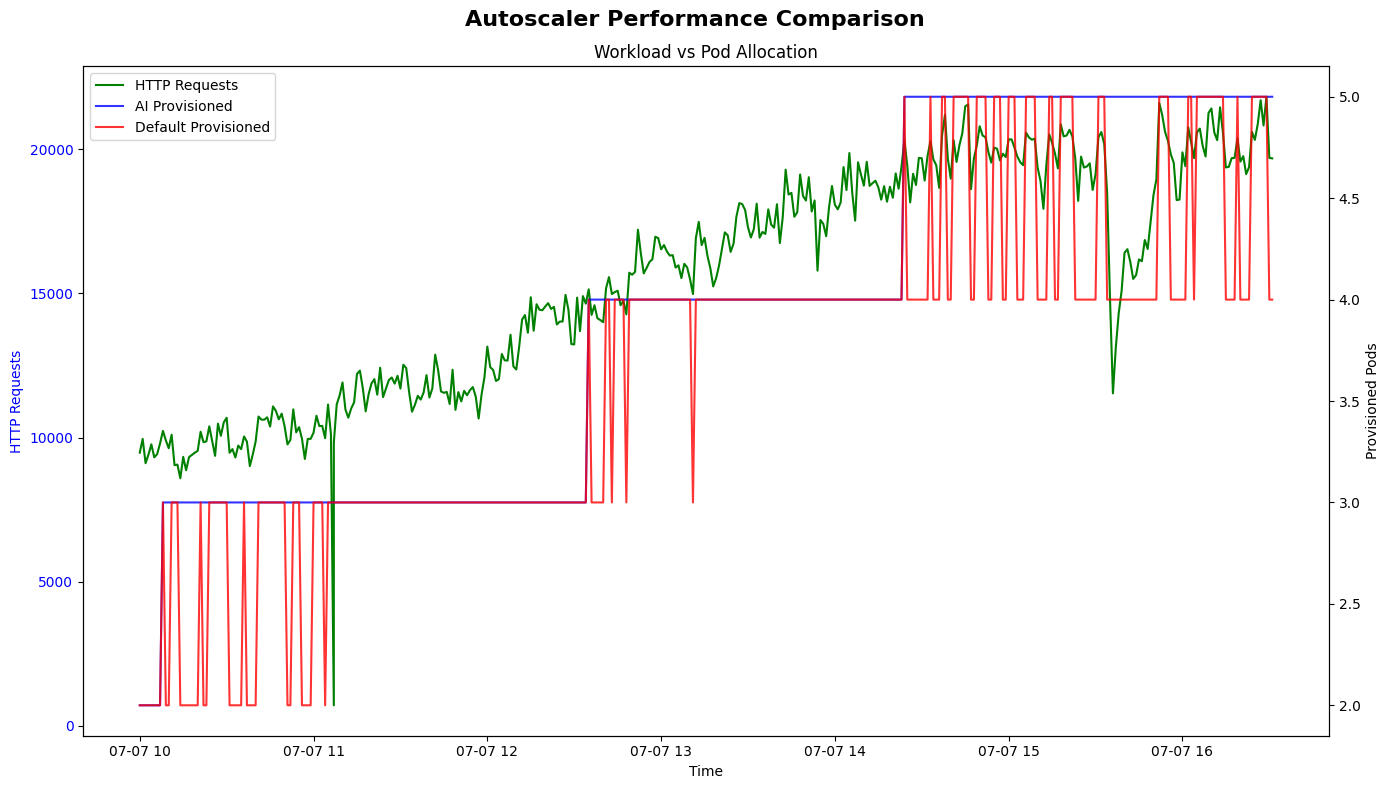

In [225]:
evaluator = AutoscalerEvaluator(workload_per_pod=workload_per_pod, initial_replicas=initial_replicas)

results = evaluator.compare_autoscalers(
    requests=data_evaluation_BilstmMd[0],
    ai_provisioned_pods=data_evaluation_BilstmMd[1],
    default_provisioned_pods=data_evaluation_BilstmMd[2]
)

print(results)

evaluator.plot_comparison(
    data_evaluation_BilstmMd[0],
    data_evaluation_BilstmMd[1],
    data_evaluation_BilstmMd[2],
    timestamps=timestamps
)

### bayesian bilstm predictor model

{'ai_metrics': {'theta_u': 0.0, 'theta_o': 13.570822731128064, 't_u': 0.0, 't_o': 38.67684478371501}, 'default_metrics': {'theta_u': 0.0, 'theta_o': 1.8447837150127222, 't_u': 0.0, 't_o': 3.816793893129771}, 'elastic_speedup': 0.573743316450476}


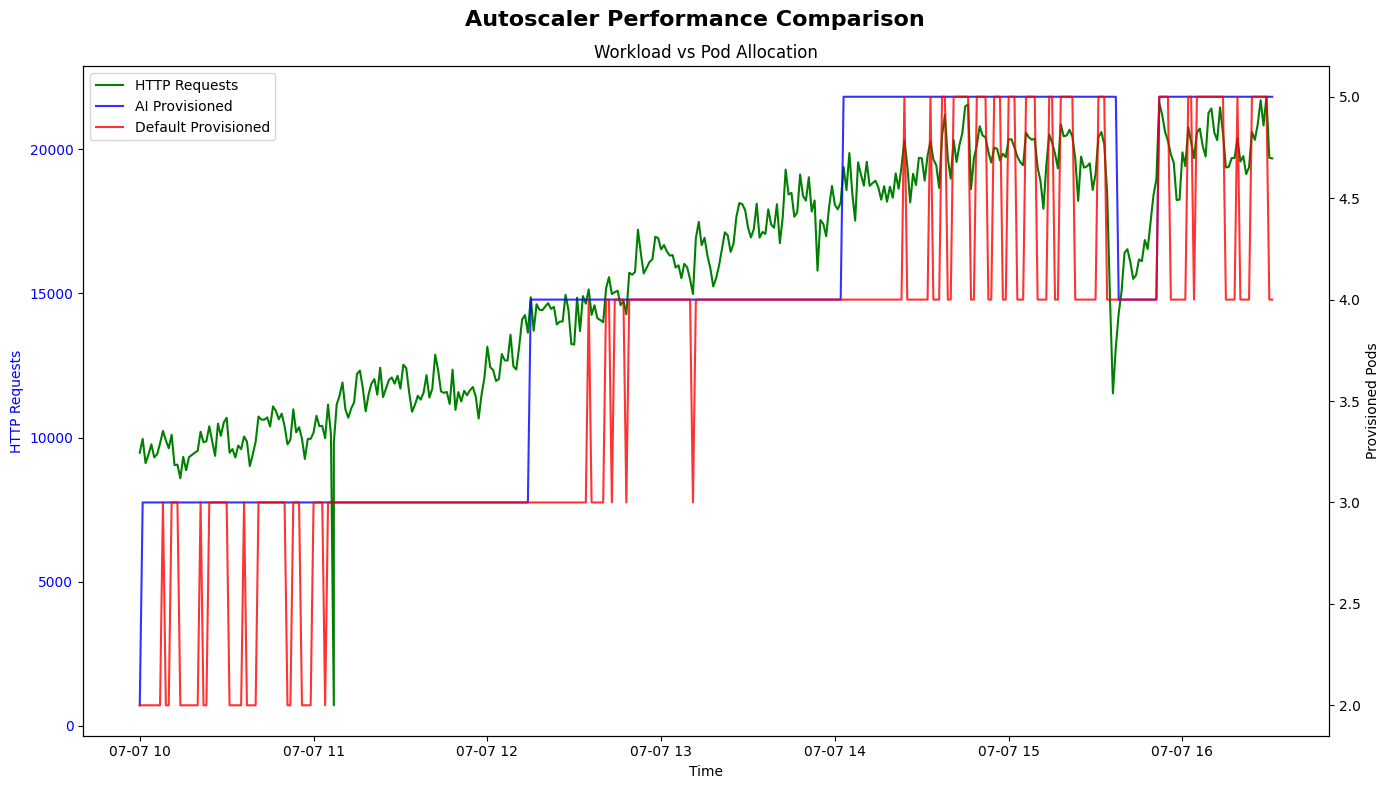

In [226]:
evaluator = AutoscalerEvaluator(workload_per_pod=workload_per_pod, initial_replicas=initial_replicas)

results = evaluator.compare_autoscalers(
    requests=data_evaluation_BoBilstm[0],
    ai_provisioned_pods=data_evaluation_BoBilstm[1],
    default_provisioned_pods=data_evaluation_BoBilstm[2]
)

print(results)

evaluator.plot_comparison(
    data_evaluation_BoBilstm[0],
    data_evaluation_BoBilstm[1],
    data_evaluation_BoBilstm[2],
    timestamps=timestamps
)
